<a href="https://colab.research.google.com/github/bikramtheitguy/CapstoneProjectHealthCareCostPrediction/blob/main/CapstoneHealthCareCostPredictionExtract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Customer ID               0
name                      0
year                      0
month                     0
date                      0
children                  0
charges                   0
Hospital tier             0
City tier                 0
State ID                  0
BMI                       0
HBA1C                     0
Heart Issues              0
Any Transplants           0
Cancer history            0
NumberOfMajorSurgeries    0
smoker                    0
dtype: int64


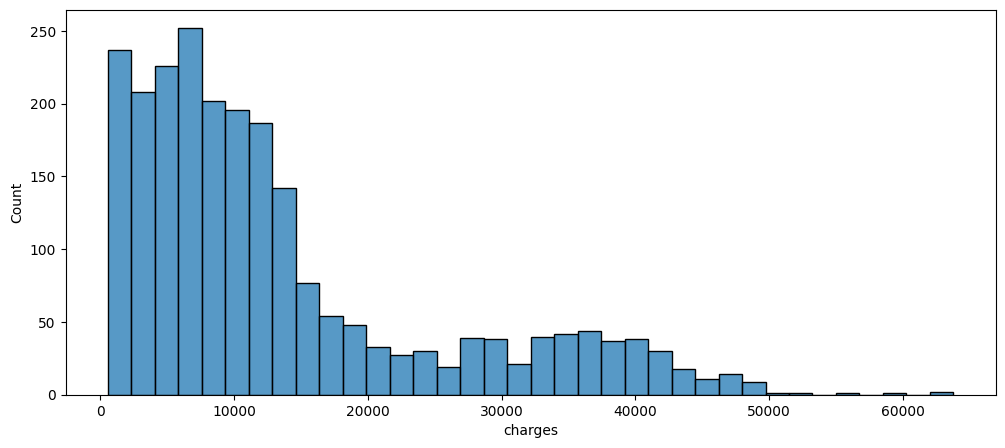

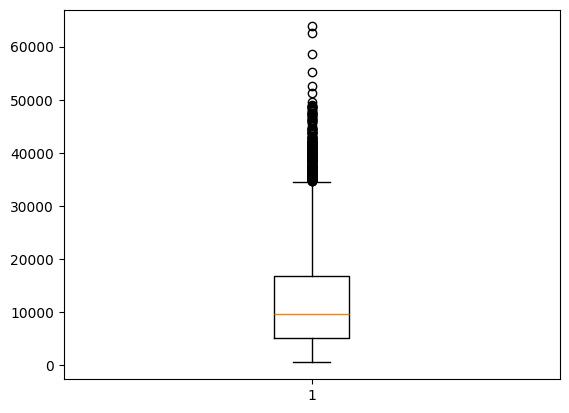

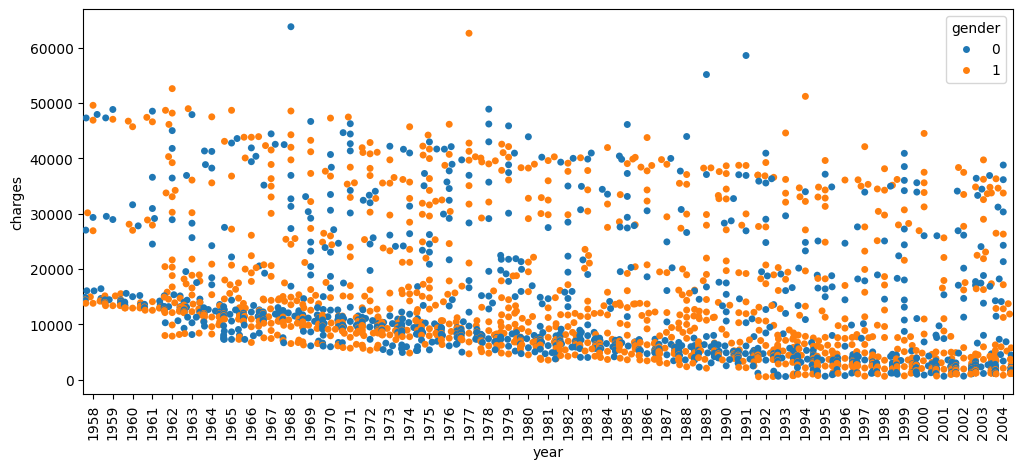

stat=2.000, p=0.368
Probably the same distribution
Fitting 5 folds for each of 39 candidates, totalling 195 fits
MAE: 2994.507641027025, MSE: 21039072.67560168, RMSE: 4586.836892195065
Predicted hospitalization cost: 36104.08660640042


In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import ttest_1samp, friedmanchisquare, kruskal, chi2_contingency
import plotly.express as px
import datetime as dt
# Import mean_absolute_error and mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Suppress warnings
warnings.filterwarnings("ignore")

# Load datasets
cust_details = pd.read_csv("Hospitalisation details.csv")
medical_details = pd.read_csv("Medical Examinations.csv")
cust_name = pd.read_excel("Names.xlsx")

# Merge data
cust_df1 = pd.merge(cust_name, cust_details, on="Customer ID")
final_df = pd.merge(cust_df1, medical_details, on="Customer ID")

# Check missing values
print(final_df.isnull().sum())

# Remove trivial values
#final_df = final_df.replace(" ", np.nan)
trivial_value = final_df[final_df.eq("?").any(axis=1)]
final_df.drop(trivial_value.index, axis=0, inplace=True)

# Encode categorical variables
le = LabelEncoder()
final_df["Heart Issues"] = le.fit_transform(final_df["Heart Issues"])
final_df["Any Transplants"] = le.fit_transform(final_df["Any Transplants"])
final_df["Cancer history"] = le.fit_transform(final_df["Cancer history"])
final_df["smoker"] = le.fit_transform(final_df["smoker"])

# Convert ordinal categorical variables
def clean_ordinal_variable(val):
    return int(val.replace("tier", "").replace(" ", "").replace("-", ""))

final_df["Hospital tier"] = final_df["Hospital tier"].map(clean_ordinal_variable)
final_df["City tier"] = final_df["City tier"].map(clean_ordinal_variable)

# Handle State ID
Dummies = pd.get_dummies(final_df["State ID"], prefix="State_ID")
Dummy = Dummies[['State_ID_R1011', 'State_ID_R1012', 'State_ID_R1013']]
final_df = pd.concat([final_df, Dummy], axis=1)
final_df.drop(['State ID'], inplace=True, axis=1)

# Clean "NumberOfMajorSurgeries" column
final_df["NumberOfMajorSurgeries"] = final_df["NumberOfMajorSurgeries"].replace("No major surgery", "0").astype(int)

# Calculate age
final_df["year"] = pd.to_datetime(final_df["year"], format='%Y').dt.year
final_df["month"] = pd.to_datetime(final_df["month"], format='%b').dt.month
final_df['DateInt'] = final_df["year"].astype(str) + final_df["month"].astype(str).str.zfill(2)
final_df['DOB'] = pd.to_datetime(final_df.DateInt, format="%Y%m")
final_df.drop(["DateInt"], inplace=True, axis=1)

current_date = dt.datetime.now()
final_df['age'] = ((current_date - final_df.DOB).dt.days / 365).astype(int)

# Extract gender from names
def gender(val):
    return 0 if "Ms." in val else 1

final_df["gender"] = final_df["name"].map(gender)

# Visualize cost distribution
plt.figure(figsize=(12,5))
sns.histplot(final_df['charges'])
plt.show()

plt.boxplot(final_df['charges'])
plt.show()

plt.figure(figsize=(12,5))
sns.swarmplot(x='year', y='charges', hue="gender", data=final_df)
plt.xticks(rotation=90)
plt.show()

# Hypothesis Testing
data1 = [32097.43]
data2 = [7168.76]
data3 = [10676.83]
stat, p = friedmanchisquare(data1, data2, data3)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')


# Feature selection
x = final_df.drop(["charges", "Customer ID", 'name', 'DOB', "year", "month"], axis=1) # Drop Customer ID and other non-numeric columns
y = final_df[['charges']]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=10)

# Standardization
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Model training using SGDRegressor with GridSearchCV
params = {
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 10.0, 100, 500],
    'penalty': ['l2', 'l1', 'elasticnet']
}

sgd = SGDRegressor()
model_cv = GridSearchCV(estimator=sgd, param_grid=params, scoring='neg_mean_absolute_error', cv=5, return_train_score=True, verbose=1)
model_cv.fit(x_train, y_train)

best_params = model_cv.best_params_
sgd = SGDRegressor(alpha=best_params['alpha'], penalty=best_params['penalty'])
sgd.fit(x_train, y_train)

# Model evaluation
y_pred = sgd.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Feature importance
importance = sgd.coef_
pd.DataFrame(importance, index=x.columns, columns=['Feature_imp'])

# Random Forest model
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(x_train, y_train)
rf_score = rf.score(x_test, y_test)

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=1000, random_state=42)
gbr.fit(x_train, y_train)
gbr_score = gbr.score(x_test, y_test)

# Predict hospitalization cost for a new patient
age = 34
BMI = 29.41
# Include a value for all 16 columns in x.columns
new_data = [[2, 1, 1, BMI, 5.8, 0, 0, 0, 0, 1, 1, 0, 0, age, 0, 1]]  # Added a '1' at the end for the missing column
df_new = pd.DataFrame(new_data, columns=x.columns)

Cost1 = sgd.predict(df_new)
Cost2 = rf.predict(df_new)
Cost3 = gbr.predict(df_new)

avg_cost = np.mean([Cost1, Cost2, Cost3])
print(f"Predicted hospitalization cost: {avg_cost}")